# Cosmology Parameter Estimation - CNN-Random Forest Ensemble

This notebook implements a two-stage ensemble approach:
1. **CNN Feature Extractor**: Learns spatial features from convergence maps
2. **Random Forest Regressor**: Predicts cosmological parameters from CNN features
3. **MCMC**: Quantifies prediction uncertainty

**Output**: Submission file with predicted cosmological parameters (Ωₘ, S₈) and uncertainties

## 1. Imports and Setup

In [23]:
import os
import json
import time
import zipfile
import datetime
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from scipy.interpolate import LinearNDInterpolator
from torchvision import transforms

import optuna

/home/teaching/miniconda3/envs/mlc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Utility Classes

In [24]:
class Utility:
    @staticmethod
    def add_noise(data, mask, ng, pixel_size=2.):
        """Add noise to a noiseless convergence map."""
        return data + np.random.randn(*data.shape) * 0.4 / (2*ng*pixel_size**2)**0.5 * mask
    
    @staticmethod
    def load_np(data_dir, file_name):
        file_path = os.path.join(data_dir, file_name)
        return np.load(file_path)

    @staticmethod
    def save_np(data_dir, file_name, data):
        file_path = os.path.join(data_dir, file_name)
        np.save(file_path, data)

    @staticmethod
    def save_json_zip(submission_dir, json_file_name, zip_file_name, data):
        """Save submission file as JSON compressed in ZIP."""
        os.makedirs(submission_dir, exist_ok=True)
        json_path = os.path.join(submission_dir, json_file_name)
        
        with open(json_path, "w") as f:
            json.dump(data, f)
        
        zip_path = os.path.join(submission_dir, zip_file_name)
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(json_path, arcname=json_file_name)
        
        os.remove(json_path)
        return zip_path


class Data:
    def __init__(self, data_dir, USE_PUBLIC_DATASET):
        self.USE_PUBLIC_DATASET = USE_PUBLIC_DATASET
        self.data_dir = data_dir
        self.mask_file = 'WIDE12H_bin2_2arcmin_mask.npy'
        self.viz_label_file = 'label.npy'
        
        if self.USE_PUBLIC_DATASET:
            self.kappa_file = 'WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = self.viz_label_file
            self.Ncosmo = 101
            self.Nsys = 256
            self.test_kappa_file = 'WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 4000
        else:
            self.kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = 'sampled_label.npy'
            self.Ncosmo = 3
            self.Nsys = 30
            self.test_kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 3
        
        self.shape = [1424, 176]
        self.pixelsize_arcmin = 2
        self.pixelsize_radian = self.pixelsize_arcmin / 60 / 180 * np.pi
        self.ng = 30

    def load_train_data(self):
        self.mask = Utility.load_np(data_dir=self.data_dir, file_name=self.mask_file)
        self.kappa = np.zeros((self.Ncosmo, self.Nsys, *self.shape), dtype=np.float16)
        self.kappa[:,:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.kappa_file)
        self.label = Utility.load_np(data_dir=self.data_dir, file_name=self.label_file)
        self.viz_label = Utility.load_np(data_dir=self.data_dir, file_name=self.viz_label_file)

    def load_test_data(self):
        self.kappa_test = np.zeros((self.Ntest, *self.shape), dtype=np.float16)
        self.kappa_test[:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.test_kappa_file)


class Score:
    @staticmethod
    def _score_phase1(true_cosmo, infer_cosmo, errorbar):
        """Computes the log-likelihood score for Phase 1."""
        sq_error = (true_cosmo - infer_cosmo)**2
        scale_factor = 1000
        score = - np.sum(sq_error / errorbar**2 + np.log(errorbar**2) + scale_factor * sq_error, 1)
        score = np.mean(score)
        return score if score >= -10**6 else -10**6

## 3. CNN-Random Forest Ensemble Models

In [25]:
class CNN_FeatureExtractor(nn.Module):
    """CNN that extracts features instead of making direct predictions."""
    
    def __init__(self, height, width, feature_dim=128, dropout1=0.2, dropout2=0.1):
        super(CNN_FeatureExtractor, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self._feature_size = self._get_conv_output_size(height, width)
        
        self.feature_extractor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._feature_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(512, feature_dim),
            nn.ReLU(),
            nn.Dropout(dropout2)
        )

    def _get_conv_output_size(self, height, width):
        dummy_input = torch.zeros(1, 1, height, width)
        output = self.conv_stack(dummy_input)
        return int(np.prod(output.size()))

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.feature_extractor(x)
        return x


class CNN_FeatureExtractor_WithHead(nn.Module):
    """CNN with auxiliary prediction head for training."""
    
    def __init__(self, height, width, num_targets, feature_dim=128, dropout1=0.2, dropout2=0.1):
        super(CNN_FeatureExtractor_WithHead, self).__init__()
        self.feature_extractor = CNN_FeatureExtractor(height, width, feature_dim, dropout1, dropout2)
        self.prediction_head = nn.Linear(feature_dim, num_targets)
        
    def forward(self, x, return_features=False):
        features = self.feature_extractor(x)
        if return_features:
            return features
        predictions = self.prediction_head(features)
        return predictions
    
    def get_feature_extractor(self):
        return self.feature_extractor


class CNN_RF_Ensemble:
    """Ensemble combining CNN feature extraction with Random Forest regression."""
    
    def __init__(self, cnn_model, rf_params=None):
        self.cnn_model = cnn_model
        self.device = next(cnn_model.parameters()).device
        
        if rf_params is None:
            rf_params = {
                'n_estimators': 200,
                'max_depth': 20,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'random_state': 42,
                'n_jobs': -1
            }
        self.rf_model = RandomForestRegressor(**rf_params)
        
    def extract_features(self, dataloader):
        """Extract features from images using CNN."""
        self.cnn_model.eval()
        features_list = []
        labels_list = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Extracting features"):
                if len(batch) == 2:
                    X, y = batch
                    X = X.to(self.device)
                    features = self.cnn_model(X)
                    features_list.append(features.cpu().numpy())
                    labels_list.append(y.numpy())
                else:
                    X = batch
                    X = X.to(self.device)
                    features = self.cnn_model(X)
                    features_list.append(features.cpu().numpy())
        
        features = np.concatenate(features_list, axis=0)
        if labels_list:
            labels = np.concatenate(labels_list, axis=0)
            return features, labels
        return features
    
    def fit_rf(self, train_loader):
        """Train Random Forest on CNN features."""
        print("Extracting training features...")
        X_train_features, y_train = self.extract_features(train_loader)
        
        print(f"Training Random Forest on {X_train_features.shape[0]} samples...")
        self.rf_model.fit(X_train_features, y_train)
        print("Random Forest training complete!")
        
    def predict(self, test_loader):
        """Make predictions using CNN features + Random Forest."""
        print("Extracting test features...")
        result = self.extract_features(test_loader)
        if isinstance(result, tuple):
            X_test_features = result[0]
        else:
            X_test_features = result
        
        print("Making predictions with Random Forest...")
        predictions = self.rf_model.predict(X_test_features)
        return predictions

## 4. Training Functions

In [26]:
def train_epoch_ensemble(model, dataloader, loss_fn, optimizer, device):
    """Training epoch for CNN with auxiliary head."""
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader), desc="Training CNN")
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        pred = model(X, return_features=False)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    return total_loss / len(dataloader)


def validate_epoch_ensemble(model, dataloader, loss_fn, device):
    """Validation epoch for CNN with auxiliary head."""
    model.eval()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader), desc="Validating CNN")
    with torch.no_grad():
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            pred = model(X, return_features=False)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.6f}'})
    return total_loss / len(dataloader)


class CosmologyDataset(Dataset):
    """Custom PyTorch Dataset."""
    
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype(np.float32)
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx].astype(np.float32)
            label = torch.from_numpy(label)
            return image, label
        else:
            return image

## 5. Configuration

In [27]:
# Paths
root_dir = os.getcwd()
USE_PUBLIC_DATASET = True
PUBLIC_DATA_DIR = '../data'
DATA_DIR = PUBLIC_DATA_DIR if USE_PUBLIC_DATASET else os.path.join(root_dir, 'input_data/')

print(f"Root directory: {root_dir}")
print(f"Data directory: {DATA_DIR}")

Root directory: /home/teaching/cosmolens/Cosmology_Challenge
Data directory: ../data


In [28]:
# Configuration for CNN-RF Ensemble
class EnsembleConfig:
    # Model architecture
    NUM_TARGETS = 2  # Omega_m, S_8
    FEATURE_DIM = 128
    DROPOUT1 = 0.2
    DROPOUT2 = 0.1
    
    # Training hyperparameters
    BATCH_SIZE = 64
    EPOCHS = 15
    LEARNING_RATE = 2e-4
    WEIGHT_DECAY = 1e-4
    
    # Random Forest hyperparameters
    RF_PARAMS = {
        'n_estimators': 200,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    CNN_MODEL_SAVE_PATH = os.path.join(root_dir, "Phase1_CNN_feature_extractor.pth")
    RF_MODEL_SAVE_PATH = os.path.join(root_dir, "Phase1_RF_model.pkl")

config = EnsembleConfig()
print(f"Device: {config.DEVICE}")
print(f"Feature dimension: {config.FEATURE_DIM}")

Device: cuda
Feature dimension: 128


## 6. Load and Prepare Data

## 6. Hyperparameter Optimization with Optuna

In [29]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    feature_dim = trial.suggest_categorical('feature_dim', [64, 128, 256])
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.3)
    dropout2 = trial.suggest_float('dropout2', 0.05, 0.2)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 100, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 10, 30)
    
    # Set image dimensions if not set
    if not hasattr(config, 'IMG_HEIGHT'):
        config.IMG_HEIGHT = data_obj.shape[0]
        config.IMG_WIDTH = data_obj.shape[1]
    
    # Update config
    config.LEARNING_RATE = learning_rate
    config.FEATURE_DIM = feature_dim
    config.DROPOUT1 = dropout1
    config.DROPOUT2 = dropout2
    config.RF_PARAMS['n_estimators'] = rf_n_estimators
    config.RF_PARAMS['max_depth'] = rf_max_depth
    
    # Initialize model
    cnn_feature_model = CNN_FeatureExtractor_WithHead(
        height=config.IMG_HEIGHT,
        width=config.IMG_WIDTH,
        num_targets=config.NUM_TARGETS,
        feature_dim=config.FEATURE_DIM,
        dropout1=config.DROPOUT1,
        dropout2=config.DROPOUT2
    ).to(config.DEVICE)
    
    # Train CNN
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(cnn_feature_model.parameters(),
                                lr=config.LEARNING_RATE,
                                weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    for epoch in range(5):  # Reduced epochs for optimization
        train_loss = train_epoch_ensemble(cnn_feature_model, train_loader, loss_fn, optimizer, config.DEVICE)
        val_loss = validate_epoch_ensemble(cnn_feature_model, val_loader, loss_fn, config.DEVICE)
        scheduler.step(val_loss)
    
    # Train RF
    feature_extractor = cnn_feature_model.get_feature_extractor()
    ensemble_model = CNN_RF_Ensemble(feature_extractor, rf_params=config.RF_PARAMS)
    ensemble_model.fit_rf(train_loader)
    
    # Predict on validation
    y_pred_val = ensemble_model.predict(val_loader)
    y_pred_val = label_scaler.inverse_transform(y_pred_val)
    
    # Compute MSE
    mse = mean_squared_error(y_val, y_pred_val)
    
    return mse

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters:")
print(study.best_params)

# Update config with best params
config.LEARNING_RATE = study.best_params['learning_rate']
config.FEATURE_DIM = study.best_params['feature_dim']
config.DROPOUT1 = study.best_params['dropout1']
config.DROPOUT2 = study.best_params['dropout2']
config.RF_PARAMS['n_estimators'] = study.best_params['rf_n_estimators']
config.RF_PARAMS['max_depth'] = study.best_params['rf_max_depth']

print("Config updated with best hyperparameters")

[I 2025-11-09 20:26:02,238] A new study created in memory with name: no-name-486d58ae-d13c-49b3-b120-e483bd7db093
Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.68it/s, loss=0.097029]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:12<00:00, 25.61it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 27.80it/s]
[I 2025-11-09 20:28:22,543] Trial 0 finished with value: 0.0014678184604775275 and parameters: {'learning_rate': 0.00021409853951892834, 'feature_dim': 256, 'dropout1': 0.1410979092155071, 'dropout2': 0.06645203251574452, 'rf_n_estimators': 210, 'rf_max_depth': 18}. Best is trial 0 with value: 0.0014678184604775275.

[I 2025-11-09 20:28:22,543] Trial 0 finished with value: 0.0014678184604775275 and parameters: {'learning_rate': 0.00021409853951892834, 'feature_dim': 256, 'dropout1': 0.1410979092155071, 'dropout2': 0.06645203251574452, 'rf_n_estimators': 210, 'rf_max_depth': 18}. Best is trial 0 with value: 0.0014678184604775275.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 29.01it/s, loss=0.079904]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 28.94it/s]


Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 29.19it/s]
[I 2025-11-09 20:30:32,289] Trial 1 finished with value: 0.0014154652112764476 and parameters: {'learning_rate': 0.0001706197209529474, 'feature_dim': 64, 'dropout1': 0.21260998378997098, 'dropout2': 0.08374652969870755, 'rf_n_estimators': 208, 'rf_max_depth': 10}. Best is trial 1 with value: 0.0014154652112764476.

[I 2025-11-09 20:30:32,289] Trial 1 finished with value: 0.0014154652112764476 and parameters: {'learning_rate': 0.0001706197209529474, 'feature_dim': 64, 'dropout1': 0.21260998378997098, 'dropout2': 0.08374652969870755, 'rf_n_estimators': 208, 'rf_max_depth': 10}. Best is trial 1 with value: 0.0014154652112764476.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.61it/s, loss=0.126042]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 29.03it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.89it/s]
[I 2025-11-09 20:32:45,279] Trial 2 finished with value: 0.0013362220710205917 and parameters: {'learning_rate': 0.0009604240939759929, 'feature_dim': 128, 'dropout1': 0.25251880116339803, 'dropout2': 0.18907845688809, 'rf_n_estimators': 257, 'rf_max_depth': 25}. Best is trial 2 with value: 0.0013362220710205917.

[I 2025-11-09 20:32:45,279] Trial 2 finished with value: 0.0013362220710205917 and parameters: {'learning_rate': 0.0009604240939759929, 'feature_dim': 128, 'dropout1': 0.25251880116339803, 'dropout2': 0.18907845688809, 'rf_n_estimators': 257, 'rf_max_depth': 25}. Best is trial 2 with value: 0.0013362220710205917.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.34it/s, loss=0.334087]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 29.15it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.41it/s]

[I 2025-11-09 20:35:01,203] Trial 3 finished with value: 0.0013358737145642027 and parameters: {'learning_rate': 0.0008409225261640427, 'feature_dim': 256, 'dropout1': 0.12053170802723608, 'dropout2': 0.11751868682808753, 'rf_n_estimators': 274, 'rf_max_depth': 10}. Best is trial 3 with value: 0.0013358737145642027.
[I 2025-11-09 20:35:01,203] Trial 3 finished with value: 0.0013358737145642027 and parameters: {'learning_rate': 0.0008409225261640427, 'feature_dim': 256, 'dropout1': 0.12053170802723608, 'dropout2': 0.11751868682808753, 'rf_n_estimators': 274, 'rf_max_depth': 10}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 27.76it/s, loss=0.799694]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.71it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 29.61it/s]

[I 2025-11-09 20:37:12,169] Trial 4 finished with value: 0.0014941303796497866 and parameters: {'learning_rate': 0.0002427988471130241, 'feature_dim': 64, 'dropout1': 0.19973267964706307, 'dropout2': 0.11417420659997882, 'rf_n_estimators': 291, 'rf_max_depth': 19}. Best is trial 3 with value: 0.0013358737145642027.
[I 2025-11-09 20:37:12,169] Trial 4 finished with value: 0.0014941303796497866 and parameters: {'learning_rate': 0.0002427988471130241, 'feature_dim': 64, 'dropout1': 0.19973267964706307, 'dropout2': 0.11417420659997882, 'rf_n_estimators': 291, 'rf_max_depth': 19}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.71it/s, loss=0.788649]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 28.83it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:03<00:00, 27.60it/s]
[I 2025-11-09 20:39:30,303] Trial 5 finished with value: 0.0022408409435152685 and parameters: {'learning_rate': 1.9653816581499447e-05, 'feature_dim': 128, 'dropout1': 0.1187754732088222, 'dropout2': 0.19095463628669418, 'rf_n_estimators': 234, 'rf_max_depth': 16}. Best is trial 3 with value: 0.0013358737145642027.

[I 2025-11-09 20:39:30,303] Trial 5 finished with value: 0.0022408409435152685 and parameters: {'learning_rate': 1.9653816581499447e-05, 'feature_dim': 128, 'dropout1': 0.1187754732088222, 'dropout2': 0.19095463628669418, 'rf_n_estimators': 234, 'rf_max_depth': 16}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.65it/s, loss=0.179758]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 28.99it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.76it/s]
[I 2025-11-09 20:41:48,427] Trial 6 finished with value: 0.0015830229333029188 and parameters: {'learning_rate': 0.00012405006444870834, 'feature_dim': 256, 'dropout1': 0.2760059804243513, 'dropout2': 0.0997646488362767, 'rf_n_estimators': 153, 'rf_max_depth': 23}. Best is trial 3 with value: 0.0013358737145642027.

[I 2025-11-09 20:41:48,427] Trial 6 finished with value: 0.0015830229333029188 and parameters: {'learning_rate': 0.00012405006444870834, 'feature_dim': 256, 'dropout1': 0.2760059804243513, 'dropout2': 0.0997646488362767, 'rf_n_estimators': 153, 'rf_max_depth': 23}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.11it/s, loss=0.500259]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 28.95it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 30.59it/s]

[I 2025-11-09 20:44:03,604] Trial 7 finished with value: 0.0014236630510701467 and parameters: {'learning_rate': 0.0006459105550295149, 'feature_dim': 256, 'dropout1': 0.18742492224784557, 'dropout2': 0.14174437365894993, 'rf_n_estimators': 177, 'rf_max_depth': 26}. Best is trial 3 with value: 0.0013358737145642027.
[I 2025-11-09 20:44:03,604] Trial 7 finished with value: 0.0014236630510701467 and parameters: {'learning_rate': 0.0006459105550295149, 'feature_dim': 256, 'dropout1': 0.18742492224784557, 'dropout2': 0.14174437365894993, 'rf_n_estimators': 177, 'rf_max_depth': 26}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 29.55it/s, loss=0.262899]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 29.05it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.48it/s]
[I 2025-11-09 20:46:12,361] Trial 8 finished with value: 0.0013660470533985087 and parameters: {'learning_rate': 0.0002630766503843268, 'feature_dim': 64, 'dropout1': 0.22712039401251707, 'dropout2': 0.16472753724428552, 'rf_n_estimators': 209, 'rf_max_depth': 10}. Best is trial 3 with value: 0.0013358737145642027.

[I 2025-11-09 20:46:12,361] Trial 8 finished with value: 0.0013660470533985087 and parameters: {'learning_rate': 0.0002630766503843268, 'feature_dim': 64, 'dropout1': 0.22712039401251707, 'dropout2': 0.16472753724428552, 'rf_n_estimators': 209, 'rf_max_depth': 10}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.81it/s, loss=0.327656]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.38it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.46it/s]

[I 2025-11-09 20:48:43,491] Trial 9 finished with value: 0.0023027273888864145 and parameters: {'learning_rate': 2.449524532164497e-05, 'feature_dim': 256, 'dropout1': 0.2233652327823957, 'dropout2': 0.059656445539339534, 'rf_n_estimators': 239, 'rf_max_depth': 29}. Best is trial 3 with value: 0.0013358737145642027.
[I 2025-11-09 20:48:43,491] Trial 9 finished with value: 0.0023027273888864145 and parameters: {'learning_rate': 2.449524532164497e-05, 'feature_dim': 256, 'dropout1': 0.2233652327823957, 'dropout2': 0.059656445539339534, 'rf_n_estimators': 239, 'rf_max_depth': 29}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 29.26it/s, loss=0.090313]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.37it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 29.84it/s]

[I 2025-11-09 20:50:58,614] Trial 10 finished with value: 0.001787135922782792 and parameters: {'learning_rate': 6.97815028931739e-05, 'feature_dim': 256, 'dropout1': 0.15954117298891946, 'dropout2': 0.14558399448528908, 'rf_n_estimators': 116, 'rf_max_depth': 15}. Best is trial 3 with value: 0.0013358737145642027.
[I 2025-11-09 20:50:58,614] Trial 10 finished with value: 0.001787135922782792 and parameters: {'learning_rate': 6.97815028931739e-05, 'feature_dim': 256, 'dropout1': 0.15954117298891946, 'dropout2': 0.14558399448528908, 'rf_n_estimators': 116, 'rf_max_depth': 15}. Best is trial 3 with value: 0.0013358737145642027.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.32it/s, loss=0.242395]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.28it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 29.48it/s]
[I 2025-11-09 20:53:11,414] Trial 11 finished with value: 0.0012912755966324463 and parameters: {'learning_rate': 0.000960382842824073, 'feature_dim': 128, 'dropout1': 0.27881996388687513, 'dropout2': 0.19911124944750652, 'rf_n_estimators': 290, 'rf_max_depth': 23}. Best is trial 11 with value: 0.0012912755966324463.

[I 2025-11-09 20:53:11,414] Trial 11 finished with value: 0.0012912755966324463 and parameters: {'learning_rate': 0.000960382842824073, 'feature_dim': 128, 'dropout1': 0.27881996388687513, 'dropout2': 0.19911124944750652, 'rf_n_estimators': 290, 'rf_max_depth': 23}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.44it/s, loss=0.240998]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 30.04it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.67it/s]

[I 2025-11-09 20:55:24,722] Trial 12 finished with value: 0.0013801674249739214 and parameters: {'learning_rate': 0.0004893059728667279, 'feature_dim': 128, 'dropout1': 0.10503486845843846, 'dropout2': 0.12543168112492456, 'rf_n_estimators': 297, 'rf_max_depth': 22}. Best is trial 11 with value: 0.0012912755966324463.
[I 2025-11-09 20:55:24,722] Trial 12 finished with value: 0.0013801674249739214 and parameters: {'learning_rate': 0.0004893059728667279, 'feature_dim': 128, 'dropout1': 0.10503486845843846, 'dropout2': 0.12543168112492456, 'rf_n_estimators': 297, 'rf_max_depth': 22}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.23it/s, loss=0.979857]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.63it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.05it/s]

[I 2025-11-09 20:57:37,748] Trial 13 finished with value: 0.0012937357145561428 and parameters: {'learning_rate': 0.0004822881105500586, 'feature_dim': 128, 'dropout1': 0.2953237285629195, 'dropout2': 0.1681874029792751, 'rf_n_estimators': 266, 'rf_max_depth': 13}. Best is trial 11 with value: 0.0012912755966324463.
[I 2025-11-09 20:57:37,748] Trial 13 finished with value: 0.0012937357145561428 and parameters: {'learning_rate': 0.0004822881105500586, 'feature_dim': 128, 'dropout1': 0.2953237285629195, 'dropout2': 0.1681874029792751, 'rf_n_estimators': 266, 'rf_max_depth': 13}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.29it/s, loss=0.124070]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.71it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 28.99it/s]
[I 2025-11-09 20:59:56,132] Trial 14 finished with value: 0.001809198304636914 and parameters: {'learning_rate': 4.712014702027789e-05, 'feature_dim': 128, 'dropout1': 0.2986617137884514, 'dropout2': 0.198958454039897, 'rf_n_estimators': 262, 'rf_max_depth': 14}. Best is trial 11 with value: 0.0012912755966324463.

[I 2025-11-09 20:59:56,132] Trial 14 finished with value: 0.001809198304636914 and parameters: {'learning_rate': 4.712014702027789e-05, 'feature_dim': 128, 'dropout1': 0.2986617137884514, 'dropout2': 0.198958454039897, 'rf_n_estimators': 262, 'rf_max_depth': 14}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 29.59it/s, loss=0.348326]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.98it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 30.34it/s]
[I 2025-11-09 21:02:11,576] Trial 15 finished with value: 0.0013134010679827662 and parameters: {'learning_rate': 0.00043127186978312334, 'feature_dim': 128, 'dropout1': 0.29881878259478306, 'dropout2': 0.1685918989601479, 'rf_n_estimators': 296, 'rf_max_depth': 30}. Best is trial 11 with value: 0.0012912755966324463.

[I 2025-11-09 21:02:11,576] Trial 15 finished with value: 0.0013134010679827662 and parameters: {'learning_rate': 0.00043127186978312334, 'feature_dim': 128, 'dropout1': 0.29881878259478306, 'dropout2': 0.1685918989601479, 'rf_n_estimators': 296, 'rf_max_depth': 30}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.59it/s, loss=0.934533]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 28.89it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 29.74it/s]
[I 2025-11-09 21:04:33,123] Trial 16 finished with value: 0.0026632333388621385 and parameters: {'learning_rate': 1.0141130358320736e-05, 'feature_dim': 128, 'dropout1': 0.26510678275852106, 'dropout2': 0.17604321040993265, 'rf_n_estimators': 237, 'rf_max_depth': 21}. Best is trial 11 with value: 0.0012912755966324463.

[I 2025-11-09 21:04:33,123] Trial 16 finished with value: 0.0026632333388621385 and parameters: {'learning_rate': 1.0141130358320736e-05, 'feature_dim': 128, 'dropout1': 0.26510678275852106, 'dropout2': 0.17604321040993265, 'rf_n_estimators': 237, 'rf_max_depth': 21}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.60it/s, loss=0.289924]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 27.61it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 29.15it/s]
[I 2025-11-09 21:06:49,304] Trial 17 finished with value: 0.0014539218082610884 and parameters: {'learning_rate': 0.00038508162416459556, 'feature_dim': 128, 'dropout1': 0.24140329918833833, 'dropout2': 0.15250607151934367, 'rf_n_estimators': 266, 'rf_max_depth': 13}. Best is trial 11 with value: 0.0012912755966324463.

[I 2025-11-09 21:06:49,304] Trial 17 finished with value: 0.0014539218082610884 and parameters: {'learning_rate': 0.00038508162416459556, 'feature_dim': 128, 'dropout1': 0.24140329918833833, 'dropout2': 0.15250607151934367, 'rf_n_estimators': 266, 'rf_max_depth': 13}. Best is trial 11 with value: 0.0012912755966324463.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.53it/s, loss=0.575402]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:10<00:00, 29.63it/s]


Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:03<00:00, 27.32it/s]
[I 2025-11-09 21:08:59,860] Trial 18 finished with value: 0.001224032224141097 and parameters: {'learning_rate': 0.0009680826927197838, 'feature_dim': 128, 'dropout1': 0.2796748246708288, 'dropout2': 0.1803260068012059, 'rf_n_estimators': 179, 'rf_max_depth': 25}. Best is trial 18 with value: 0.001224032224141097.

[I 2025-11-09 21:08:59,860] Trial 18 finished with value: 0.001224032224141097 and parameters: {'learning_rate': 0.0009680826927197838, 'feature_dim': 128, 'dropout1': 0.2796748246708288, 'dropout2': 0.1803260068012059, 'rf_n_estimators': 179, 'rf_max_depth': 25}. Best is trial 18 with value: 0.001224032224141097.


Making predictions with Random Forest...


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.52it/s, loss=1.255021]


Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 29.15it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
Extracting test features...
Random Forest training complete!
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:03<00:00, 27.41it/s]
[I 2025-11-09 21:11:10,238] Trial 19 finished with value: 0.0012500342108654242 and parameters: {'learning_rate': 0.000990250144881916, 'feature_dim': 128, 'dropout1': 0.27228178830394295, 'dropout2': 0.18017731678058638, 'rf_n_estimators': 168, 'rf_max_depth': 27}. Best is trial 18 with value: 0.001224032224141097.

[I 2025-11-09 21:11:10,238] Trial 19 finished with value: 0.0012500342108654242 and parameters: {'learning_rate': 0.000990250144881916, 'feature_dim': 128, 'dropout1': 0.27228178830394295, 'dropout2': 0.18017731678058638, 'rf_n_estimators': 168, 'rf_max_depth': 27}. Best is trial 18 with value: 0.001224032224141097.


Making predictions with Random Forest...
Best hyperparameters:
{'learning_rate': 0.0009680826927197838, 'feature_dim': 128, 'dropout1': 0.2796748246708288, 'dropout2': 0.1803260068012059, 'rf_n_estimators': 179, 'rf_max_depth': 25}
Config updated with best hyperparameters


## 7. Load and Prepare Data

In [30]:
# Initialize and load data
data_obj = Data(data_dir=DATA_DIR, USE_PUBLIC_DATASET=USE_PUBLIC_DATASET)
data_obj.load_train_data()
data_obj.load_test_data()

print(f"Cosmologies: {data_obj.Ncosmo}, Realizations: {data_obj.Nsys}")
print(f"Training data shape: {data_obj.kappa.shape}")
print(f"Test data shape: {data_obj.kappa_test.shape}")

Cosmologies: 101, Realizations: 256
Training data shape: (101, 256, 1424, 176)
Test data shape: (4000, 1424, 176)


In [31]:
# Load preprocessed train/val split
noisy_kappa_train = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_train.npy")
label_train = Utility.load_np(data_dir=DATA_DIR, file_name="label_train.npy")
noisy_kappa_val = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_val.npy")
label_val = Utility.load_np(data_dir=DATA_DIR, file_name="label_val.npy")

Ntrain = label_train.shape[0] * label_train.shape[1]
Nval = label_val.shape[0] * label_val.shape[1]

# Reshape for CNN
X_train = noisy_kappa_train.reshape(Ntrain, *data_obj.shape)
X_val = noisy_kappa_val.reshape(Nval, *data_obj.shape)
y_train = label_train.reshape(Ntrain, 5)[:, :2]  # Only Omega_m, S_8
y_val = label_val.reshape(Nval, 5)[:, :2]

print(f"Training: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation: {X_val.shape}, Labels: {y_val.shape}")

Training: (20604, 1424, 176), Labels: (20604, 2)
Validation: (5252, 1424, 176), Labels: (5252, 2)


In [32]:
# Standardize data
means = np.mean(X_train, dtype=np.float32)
stds = np.std(X_train, dtype=np.float32)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[means], std=[stds]),
])

label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train)
y_val_scaled = label_scaler.transform(y_val)

print(f"Image stats - Mean: {means:.6f}, Std: {stds:.6f}")
print(f"Label stats - Mean: {label_scaler.mean_}, Std: {np.sqrt(label_scaler.var_)}")

Image stats - Mean: -0.000147, Std: 0.020474
Label stats - Mean: [0.29021683 0.81345297], Std: [0.1055216  0.06600116]


In [33]:
# Create datasets and dataloaders
train_dataset = CosmologyDataset(X_train, y_train_scaled, transform)
val_dataset = CosmologyDataset(X_val, y_val_scaled, transform)
test_dataset = CosmologyDataset(data_obj.kappa_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 322, Val batches: 83, Test batches: 63


## 9. Train CNN-RF Ensemble

In [35]:
# Initialize model
config.IMG_HEIGHT = data_obj.shape[0]
config.IMG_WIDTH = data_obj.shape[1]

cnn_feature_model = CNN_FeatureExtractor_WithHead(
    height=config.IMG_HEIGHT,
    width=config.IMG_WIDTH,
    num_targets=config.NUM_TARGETS,
    feature_dim=config.FEATURE_DIM,
    dropout1=config.DROPOUT1,
    dropout2=config.DROPOUT2
).to(config.DEVICE)

print(f"Model initialized on {config.DEVICE}")

Model initialized on cuda


In [36]:
# Training control
USE_PRETRAINED_ENSEMBLE = False  # Set to True to load pretrained models

if not USE_PRETRAINED_ENSEMBLE:
    print("=" * 70)
    print("STEP 1: Training CNN Feature Extractor")
    print("=" * 70)
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(cnn_feature_model.parameters(),
                                lr=config.LEARNING_RATE,
                                weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    start_time = time.time()
    
    for epoch in range(config.EPOCHS):
        train_loss = train_epoch_ensemble(cnn_feature_model, train_loader, loss_fn, optimizer, config.DEVICE)
        val_loss = validate_epoch_ensemble(cnn_feature_model, val_loader, loss_fn, config.DEVICE)
        
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{config.EPOCHS} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(cnn_feature_model.state_dict(), config.CNN_MODEL_SAVE_PATH)
            print(f"  ✓ Best model saved!")
    
    print(f"\nCNN training completed in {(time.time() - start_time)/60:.2f} minutes")
    
    # Load best model
    cnn_feature_model.load_state_dict(torch.load(config.CNN_MODEL_SAVE_PATH, weights_only=True))
    
    print("\n" + "=" * 70)
    print("STEP 2: Training Random Forest")
    print("=" * 70)
    
    feature_extractor = cnn_feature_model.get_feature_extractor()
    ensemble_model = CNN_RF_Ensemble(feature_extractor, rf_params=config.RF_PARAMS)
    ensemble_model.fit_rf(train_loader)
    
    # Save RF model
    with open(config.RF_MODEL_SAVE_PATH, 'wb') as f:
        pickle.dump(ensemble_model.rf_model, f)
    print(f"✓ Random Forest saved to {config.RF_MODEL_SAVE_PATH}")
    
    print("\n" + "=" * 70)
    print("✓ Ensemble Training Complete!")
    print("=" * 70)
    
else:
    print("Loading pretrained ensemble models...")
    if os.path.exists(config.CNN_MODEL_SAVE_PATH) and os.path.exists(config.RF_MODEL_SAVE_PATH):
        cnn_feature_model.load_state_dict(torch.load(config.CNN_MODEL_SAVE_PATH, weights_only=True))
        feature_extractor = cnn_feature_model.get_feature_extractor()
        ensemble_model = CNN_RF_Ensemble(feature_extractor, rf_params=config.RF_PARAMS)
        with open(config.RF_MODEL_SAVE_PATH, 'rb') as f:
            ensemble_model.rf_model = pickle.load(f)
        print("✓ Models loaded successfully!")
    else:
        raise FileNotFoundError("Pretrained models not found. Set USE_PRETRAINED_ENSEMBLE=False to train.")

STEP 1: Training CNN Feature Extractor


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 27.73it/s, loss=2.978139]



Epoch 1/15 | Train: 1.890780 | Val: 0.892443
  ✓ Best model saved!


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.66it/s, loss=2.044532]



Epoch 2/15 | Train: 0.700408 | Val: 0.655253
  ✓ Best model saved!


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 26.52it/s, loss=0.569636]



Epoch 3/15 | Train: 0.300770 | Val: 0.269584
  ✓ Best model saved!


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.43it/s, loss=0.226287]


Epoch 4/15 | Train: 0.212290 | Val: 0.287228


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 26.99it/s, loss=0.139660]


Epoch 5/15 | Train: 0.195657 | Val: 0.380407


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 27.86it/s, loss=1.509160]


Epoch 6/15 | Train: 0.175964 | Val: 0.370600


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.16it/s, loss=1.422656]


Epoch 7/15 | Train: 0.156880 | Val: 0.330736


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.54it/s, loss=2.001365]


Epoch 8/15 | Train: 0.149679 | Val: 0.466335


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.24it/s, loss=0.303839]



Epoch 9/15 | Train: 0.134143 | Val: 0.209936
  ✓ Best model saved!


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.15it/s, loss=0.528030]



Epoch 10/15 | Train: 0.136119 | Val: 0.206090
  ✓ Best model saved!


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.18it/s, loss=1.983950]


Epoch 11/15 | Train: 0.127985 | Val: 0.467119


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 27.96it/s, loss=0.562791]


Epoch 12/15 | Train: 0.127025 | Val: 0.217682


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.61it/s, loss=2.079105]


Epoch 13/15 | Train: 0.134478 | Val: 0.472291


Validating CNN: 100%|██████████| 83/83 [00:03<00:00, 27.59it/s, loss=0.830772]


Epoch 14/15 | Train: 0.117134 | Val: 0.237514


Validating CNN: 100%|██████████| 83/83 [00:02<00:00, 28.04it/s, loss=1.185406]



Epoch 15/15 | Train: 0.117955 | Val: 0.278546

CNN training completed in 5.75 minutes

STEP 2: Training Random Forest
Extracting training features...


Extracting features: 100%|██████████| 322/322 [00:11<00:00, 28.14it/s]



Training Random Forest on 20604 samples...
Random Forest training complete!
✓ Random Forest saved to /home/teaching/cosmolens/Cosmology_Challenge/Phase1_RF_model.pkl

✓ Ensemble Training Complete!
Random Forest training complete!
✓ Random Forest saved to /home/teaching/cosmolens/Cosmology_Challenge/Phase1_RF_model.pkl

✓ Ensemble Training Complete!


## 10. Validation Predictions and Evaluation

In [37]:
# Make validation predictions
print("Making predictions on validation set...")
y_pred_val_ensemble = ensemble_model.predict(val_loader)
y_pred_val_ensemble = label_scaler.inverse_transform(y_pred_val_ensemble)

print(f"Predictions shape: {y_pred_val_ensemble.shape}")

Making predictions on validation set...
Extracting test features...


Extracting features: 100%|██████████| 83/83 [00:02<00:00, 27.81it/s]

Making predictions with Random Forest...
Predictions shape: (5252, 2)


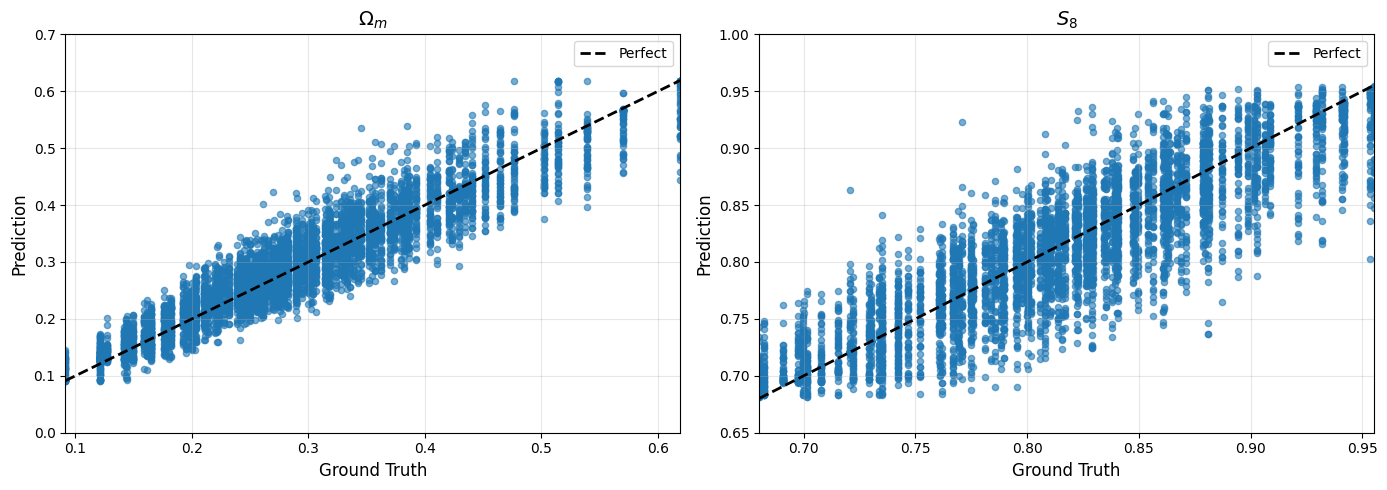


Validation Metrics:
  Ωₘ - MSE: 0.001417, R²: 0.8728
  S₈ - MSE: 0.001116, R²: 0.7439


In [38]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Omega_m
axes[0].scatter(y_val[:,0], y_pred_val_ensemble[:,0], alpha=0.6, s=20)
axes[0].plot(sorted(y_val[:,0]), sorted(y_val[:,0]), 'k--', linewidth=2, label='Perfect')
axes[0].set_xlim(np.min(y_val[:,0]), np.max(y_val[:,0]))
axes[0].set_ylim(0, 0.7)
axes[0].set_xlabel('Ground Truth', fontsize=12)
axes[0].set_ylabel('Prediction', fontsize=12)
axes[0].set_title(r'$\Omega_m$', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# S_8
axes[1].scatter(y_val[:,1], y_pred_val_ensemble[:,1], alpha=0.6, s=20)
axes[1].plot(sorted(y_val[:,1]), sorted(y_val[:,1]), 'k--', linewidth=2, label='Perfect')
axes[1].set_xlim(np.min(y_val[:,1]), np.max(y_val[:,1]))
axes[1].set_ylim(0.65, 1)
axes[1].set_xlabel('Ground Truth', fontsize=12)
axes[1].set_ylabel('Prediction', fontsize=12)
axes[1].set_title(r'$S_8$', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Metrics
mse_om = mean_squared_error(y_val[:,0], y_pred_val_ensemble[:,0])
mse_s8 = mean_squared_error(y_val[:,1], y_pred_val_ensemble[:,1])
r2_om = r2_score(y_val[:,0], y_pred_val_ensemble[:,0])
r2_s8 = r2_score(y_val[:,1], y_pred_val_ensemble[:,1])

print(f"\nValidation Metrics:")
print(f"  Ωₘ - MSE: {mse_om:.6f}, R²: {r2_om:.4f}")
print(f"  S₈ - MSE: {mse_s8:.6f}, R²: {r2_s8:.4f}")

## 11. MCMC Uncertainty Quantification (Validation)

In [39]:
# Prepare summary statistics for MCMC
cosmology = data_obj.label[:,0,:2]
Ncosmo = data_obj.Ncosmo

# Group validation indices by cosmology
row_to_i = {tuple(cosmology[i]): i for i in range(Ncosmo)}
index_lists = [[] for _ in range(Ncosmo)]

for idx in range(len(y_val)):
    row_tuple = tuple(y_val[idx])
    i = row_to_i[row_tuple]
    index_lists[i].append(idx)

val_cosmology_idx = [np.array(lst) for lst in index_lists]

# Compute summary statistics
d_vector = []
n_d = 2

for i in range(Ncosmo):
    d_i = np.zeros((len(val_cosmology_idx[i]), n_d))
    for j, idx in enumerate(val_cosmology_idx[i]):
        d_i[j] = y_pred_val_ensemble[idx]
    d_vector.append(d_i)

# Mean and covariance
mean_d_vector = np.array([np.mean(d_vector[i], 0) for i in range(Ncosmo)])

delta = [d_vector[i] - mean_d_vector[i].reshape(1, n_d) for i in range(Ncosmo)]
cov_d_vector = np.concatenate([(delta[i].T @ delta[i] / (len(delta[i])-n_d-2))[None] 
                                for i in range(Ncosmo)], 0)

print("Summary statistics computed")

Summary statistics computed


In [40]:
# Create interpolators for MCMC
mean_d_vector_interp = LinearNDInterpolator(cosmology, mean_d_vector, fill_value=np.nan)
cov_d_vector_interp = LinearNDInterpolator(cosmology, cov_d_vector, fill_value=np.nan)
logprior_interp = LinearNDInterpolator(cosmology, np.zeros((Ncosmo, 1)), fill_value=-np.inf)

def log_prior(x):
    return logprior_interp(x).flatten()

def loglike(x, d):
    mean = mean_d_vector_interp(x)
    cov = cov_d_vector_interp(x)
    delta = d - mean
    inv_cov = np.linalg.inv(cov)
    cov_det = np.linalg.slogdet(cov)[1]
    return -0.5 * cov_det - 0.5 * np.einsum("ni,nij,nj->n", delta, inv_cov, delta)

def logp_posterior(x, d):
    logp = log_prior(x)
    select = np.isfinite(logp)
    if np.sum(select) > 0:
        logp[select] = logp[select] + loglike(x[select], d[select])
    return logp

print("Interpolators ready for MCMC")

Interpolators ready for MCMC


In [41]:
# Run MCMC for validation set
Nstep = 10000
sigma = 0.06

current = cosmology[np.random.choice(Ncosmo, size=Nval)]
curr_logprob = logp_posterior(current, y_pred_val_ensemble)

states = []
total_acc = np.zeros(len(current))

print("Running MCMC on validation set...")
t = time.time()

for i in range(Nstep):
    proposal = current + np.random.randn(*current.shape) * sigma
    proposal_logprob = logp_posterior(proposal, y_pred_val_ensemble)
    
    acc_logprob = proposal_logprob - curr_logprob
    acc_logprob[acc_logprob > 0] = 0
    acc_prob = np.exp(acc_logprob)
    acc = np.random.uniform(size=len(current)) < acc_prob
    
    total_acc += acc_prob
    current[acc] = proposal[acc]
    curr_logprob[acc] = proposal_logprob[acc]
    states.append(np.copy(current)[None])
    
    if i % 1000 == 999:
        print(f"Step {i+1}/{Nstep} | Acc rate: {np.mean(total_acc/(i+1)):.3f}")

# Remove burn-in and compute statistics
states = np.concatenate(states[int(0.2*Nstep):], 0)
mean_val = np.mean(states, 0)
errorbar_val = np.std(states, 0)

print(f"\nMCMC complete! Mean error bars: {np.mean(errorbar_val, 0)}")

Running MCMC on validation set...
Step 1000/10000 | Acc rate: 0.298
Step 1000/10000 | Acc rate: 0.298
Step 2000/10000 | Acc rate: 0.297
Step 2000/10000 | Acc rate: 0.297
Step 3000/10000 | Acc rate: 0.297
Step 3000/10000 | Acc rate: 0.297
Step 4000/10000 | Acc rate: 0.297
Step 4000/10000 | Acc rate: 0.297
Step 5000/10000 | Acc rate: 0.297
Step 5000/10000 | Acc rate: 0.297
Step 6000/10000 | Acc rate: 0.297
Step 6000/10000 | Acc rate: 0.297
Step 7000/10000 | Acc rate: 0.297
Step 7000/10000 | Acc rate: 0.297
Step 8000/10000 | Acc rate: 0.297
Step 8000/10000 | Acc rate: 0.297
Step 9000/10000 | Acc rate: 0.297
Step 9000/10000 | Acc rate: 0.297
Step 10000/10000 | Acc rate: 0.297
Step 10000/10000 | Acc rate: 0.297

MCMC complete! Mean error bars: [0.03848334 0.03170893]

MCMC complete! Mean error bars: [0.03848334 0.03170893]


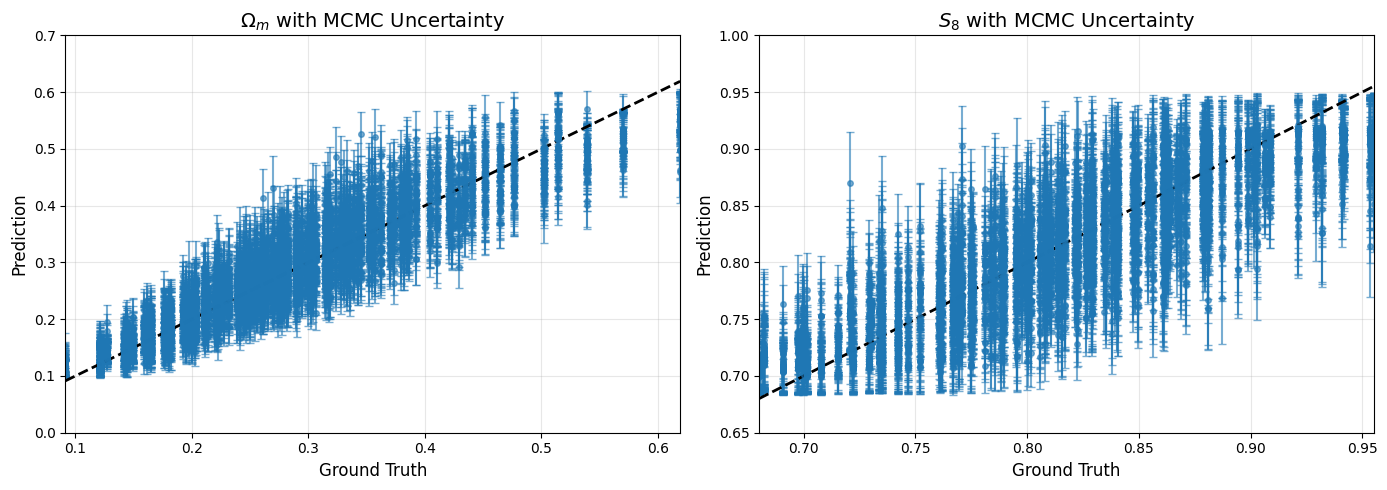

In [42]:
# Visualize MCMC results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].errorbar(y_val[:,0], mean_val[:,0], yerr=errorbar_val[:,0],
                 fmt='o', capsize=3, alpha=0.6, markersize=4)
axes[0].plot(sorted(y_val[:,0]), sorted(y_val[:,0]), 'k--', linewidth=2)
axes[0].set_xlim(np.min(y_val[:,0]), np.max(y_val[:,0]))
axes[0].set_ylim(0, 0.7)
axes[0].set_xlabel('Ground Truth', fontsize=12)
axes[0].set_ylabel('Prediction', fontsize=12)
axes[0].set_title(r'$\Omega_m$ with MCMC Uncertainty', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].errorbar(y_val[:,1], mean_val[:,1], yerr=errorbar_val[:,1],
                 fmt='o', capsize=3, alpha=0.6, markersize=4)
axes[1].plot(sorted(y_val[:,1]), sorted(y_val[:,1]), 'k--', linewidth=2)
axes[1].set_xlim(np.min(y_val[:,1]), np.max(y_val[:,1]))
axes[1].set_ylim(0.65, 1)
axes[1].set_xlabel('Ground Truth', fontsize=12)
axes[1].set_ylabel('Prediction', fontsize=12)
axes[1].set_title(r'$S_8$ with MCMC Uncertainty', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# Calculate validation score
validation_score = Score._score_phase1(y_val, mean_val, errorbar_val)

print('=' * 70)
print('VALIDATION RESULTS')
print('=' * 70)
print(f'Score: {validation_score:.2f}')
print(f'Error bar (Ωₘ): {np.mean(errorbar_val[:, 0]):.6f}')
print(f'Error bar (S₈): {np.mean(errorbar_val[:, 1]):.6f}')
print('=' * 70)

VALIDATION RESULTS
Score: 9.00
Error bar (Ωₘ): 0.038483
Error bar (S₈): 0.031709


## 12. Test Set Predictions

In [44]:
# Make test predictions
print("Making predictions on test set...")
y_pred_test = ensemble_model.predict(test_loader)
y_pred_test = label_scaler.inverse_transform(y_pred_test)

print(f"Test predictions shape: {y_pred_test.shape}")
print(f"Sample predictions:\n{y_pred_test[:3]}")

Making predictions on test set...
Extracting test features...


Extracting features: 100%|██████████| 63/63 [00:05<00:00, 11.06it/s]

Making predictions with Random Forest...
Test predictions shape: (4000, 2)
Sample predictions:
[[0.33738631 0.825502  ]
 [0.2615869  0.9326238 ]
 [0.30628381 0.86919268]]


In [45]:
# Run MCMC for test set
Nstep_test = 10000
sigma_test = 0.06

current_test = cosmology[np.random.choice(Ncosmo, size=data_obj.Ntest)]
curr_logprob_test = logp_posterior(current_test, y_pred_test)

states_test = []
total_acc_test = np.zeros(len(current_test))

print("Running MCMC on test set...")
t = time.time()

for i in range(Nstep_test):
    proposal = current_test + np.random.randn(*current_test.shape) * sigma_test
    proposal_logprob = logp_posterior(proposal, y_pred_test)
    
    acc_logprob = proposal_logprob - curr_logprob_test
    acc_logprob[acc_logprob > 0] = 0
    acc_prob = np.exp(acc_logprob)
    acc = np.random.uniform(size=len(current_test)) < acc_prob
    
    total_acc_test += acc_prob
    current_test[acc] = proposal[acc]
    curr_logprob_test[acc] = proposal_logprob[acc]
    states_test.append(np.copy(current_test)[None])
    
    if i % 1000 == 999:
        print(f"Step {i+1}/{Nstep_test} | Acc rate: {np.mean(total_acc_test/(i+1)):.3f}")

# Remove burn-in and compute statistics
states_test = np.concatenate(states_test[int(0.2*Nstep_test):], 0)
mean_test = np.mean(states_test, 0)
errorbar_test = np.std(states_test, 0)

print(f"\nMCMC complete! Mean error bars: {np.mean(errorbar_test, 0)}")

Running MCMC on test set...
Step 1000/10000 | Acc rate: 0.298
Step 1000/10000 | Acc rate: 0.298
Step 2000/10000 | Acc rate: 0.298
Step 2000/10000 | Acc rate: 0.298
Step 3000/10000 | Acc rate: 0.298
Step 3000/10000 | Acc rate: 0.298
Step 4000/10000 | Acc rate: 0.298
Step 4000/10000 | Acc rate: 0.298
Step 5000/10000 | Acc rate: 0.298
Step 5000/10000 | Acc rate: 0.298
Step 6000/10000 | Acc rate: 0.297
Step 6000/10000 | Acc rate: 0.297
Step 7000/10000 | Acc rate: 0.297
Step 7000/10000 | Acc rate: 0.297
Step 8000/10000 | Acc rate: 0.297
Step 8000/10000 | Acc rate: 0.297
Step 9000/10000 | Acc rate: 0.297
Step 9000/10000 | Acc rate: 0.297
Step 10000/10000 | Acc rate: 0.297
Step 10000/10000 | Acc rate: 0.297

MCMC complete! Mean error bars: [0.03841492 0.03175781]

MCMC complete! Mean error bars: [0.03841492 0.03175781]


## 13. Generate Submission File

In [46]:
# Create submission
data_submission = {
    "means": mean_test.tolist(),
    "errorbars": errorbar_test.tolist()
}

timestamp = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
zip_file_name = f'Submission_Ensemble_{timestamp}.zip'

zip_file = Utility.save_json_zip(
    submission_dir="submissions",
    json_file_name="result.json",
    zip_file_name=zip_file_name,
    data=data_submission
)

print("=" * 70)
print("✓ SUBMISSION FILE CREATED")
print("=" * 70)
print(f"File: {zip_file}")
print(f"Test samples: {len(mean_test)}")
print(f"Parameters per sample: {mean_test.shape[1]} (Ωₘ, S₈)")
print("=" * 70)

✓ SUBMISSION FILE CREATED
File: submissions/Submission_Ensemble_25-11-09-22-07.zip
Test samples: 4000
Parameters per sample: 2 (Ωₘ, S₈)


## 14. Summary

### Pipeline Overview
1. **CNN Feature Extractor** (128-dim features)
   - 4 convolutional blocks with batch normalization
   - Trained with auxiliary prediction head

2. **Random Forest Regressor** (200 trees)
   - Trained on CNN-extracted features
   - Predicts cosmological parameters

3. **MCMC Uncertainty Quantification**
   - Metropolis-Hastings sampling
   - 10,000 steps with 20% burn-in

### Key Advantages
- ✓ CNN captures spatial patterns in convergence maps
- ✓ Random Forest provides robust non-linear predictions
- ✓ Ensemble reduces overfitting
- ✓ MCMC provides calibrated uncertainty estimates

### Output
- **means**: Predicted [Ωₘ, S₈] for each test sample
- **errorbars**: Uncertainty estimates from MCMC